# Multiple testing

In this notebook you will see different methods on how to deal with multiple testing. This situation can occur if you calculate multiple features from a set of two samples:
* Calculating 10 features (shape, size, etc.) from two cell populations
* Running gene expression analysis with hundreds of genes from few patient samples

As explained in the presentation, the risk of detecting false positives increases with the number of tests conducted. In this notebook you'll see how to use some correction methods:

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats import multitest

In [2]:
np.random.seed(42)

We first assume that we draw our samples from a normal distribution. This function is just to be able to draw a nice curve:

In [3]:
def gaussian(x, mean, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mean)**2/sigma**2)

When drawing samples from different distributions, we usually try to show that the distributions are different. This corresponds to the following null hypothesis: The mean $\mu$ of distribution 1 and 2 are equal ($\mu_1 = \mu_2$). We will play through two scenarios here (in reality we don't know which is the case):

* $\mu_1 = \mu_2$
* $\mu_1 \neq \mu_2$

In [4]:
mean1 = 0  # mean of distribution 1
mean2 = 0  # mean of distribution 2
mean3 = 0.1  # mean of distribution 2 if H0 not true
sigma1 = 1  # width of distributions
sigma2 = 1
sigma3 = 1
n_samples_from_1 = 50  # how many samples to draw from distribution 1
n_samples_from_2 = 50  # how many samples to draw from distribution 2

Let's plot the distributions we are looking at:

Text(0.5, 1.0, 'H0 is not true')

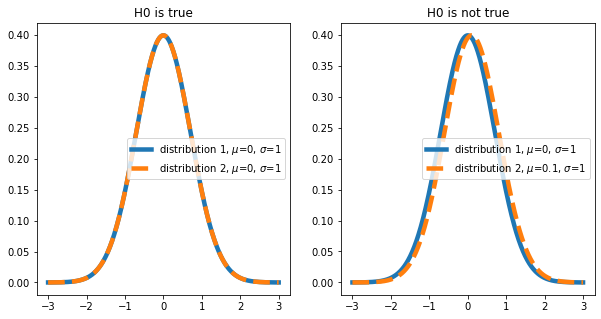

In [5]:
x = np.linspace(-3, 3, 1000)
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
_ = axes[0].plot(x, gaussian(x, mean1, sigma1), label=f'distribution 1, $\\mu$={mean1}, $\\sigma$={sigma1}', linewidth=4.5)
_ = axes[0].plot(x, gaussian(x, mean2, sigma2), label = f'distribution 2, $\\mu$={mean2}, $\\sigma$={sigma2}', linestyle='--', linewidth=4.5)
axes[0].legend()
axes[0].set_title('H0 is true')

_ = axes[1].plot(x, gaussian(x, mean1, sigma1), label=f'distribution 1, $\\mu$={mean1}, $\\sigma$={sigma1}', linewidth=4.5)
_ = axes[1].plot(x, gaussian(x, mean3, sigma2), label = f'distribution 2, $\\mu$={mean3}, $\\sigma$={sigma3}', linestyle='--', linewidth=4.5)
axes[1].legend()
axes[1].set_title('H0 is not true')

Now, let's draw some data from these distributions (i.e., conduct an experiment) with `np.random.normal()`. For a single test. this could look like this:

In [6]:
sampled_data_1 = np.random.normal(loc=mean1, scale=sigma1, size=1000)
sampled_data_2 = np.random.normal(loc=mean2, scale=sigma2, size=1000)
sampled_data_3 = np.random.normal(loc=mean3, scale=sigma2, size=1000)

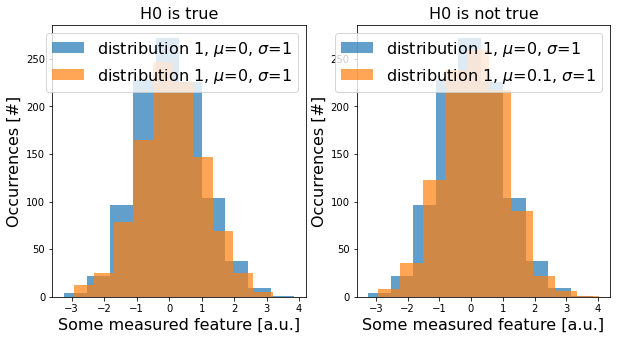

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
_ = axes[0].hist(sampled_data_1, label=f'distribution 1, $\\mu$={mean1}, $\\sigma$={sigma1}', alpha=0.7)
_ = axes[0].hist(sampled_data_2, label=f'distribution 1, $\\mu$={mean2}, $\\sigma$={sigma2}', alpha=0.7)
axes[0].legend(fontsize=16)
axes[0].set_title('H0 is true', fontsize=16)

_ = axes[1].hist(sampled_data_1, label=f'distribution 1, $\\mu$={mean1}, $\\sigma$={sigma1}', alpha=0.7)
_ = axes[1].hist(sampled_data_3, label=f'distribution 1, $\\mu$={mean3}, $\\sigma$={sigma3}', alpha=0.7)
axes[1].legend(fontsize=16)
axes[1].set_title('H0 is not true', fontsize=16)

for ax in axes:
    ax.set_xlabel('Some measured feature [a.u.]', fontsize=16)
    ax.set_ylabel('Occurrences [#]', fontsize=16)

In reality, we do repeat the same experiment multiple times or we compare several features of the same data. We then run two-sided t-tests between the samples we drew from distribution 1 and 2 for the above-introduced cases (H0 true and H0 false). Each t-test gives us a p-value:

In [8]:
pvalues12_H0_true = []
for i in range(n_samples_from_1):
    result = stats.ttest_ind(np.random.normal(loc=mean1, scale=sigma1, size=1000),
                             np.random.normal(loc=mean2, scale=sigma2, size=1000))
    pvalues12_H0_true.append(result.pvalue)

pvalues12_H0_false = []
for i in range(n_samples_from_2):
    result = stats.ttest_ind(np.random.normal(loc=mean1, scale=sigma1, size=1000),
                             np.random.normal(loc=mean3, scale=sigma2, size=1000))
    pvalues12_H0_false.append(result.pvalue)

Let's look at all p-values we calculated in a histogram - again separate for the two cases of H0 being true and false. For the case of H0 being true, you can clearly see that there is a number of significant ($p<0.05$) looking tests! These are false positives. Conversely, if H0 is not true, we also see quite some tests with $p>0.05$ - these are false negatives.

Text(0.5, 1.0, 'H0 is not true (n_tests = 50)')

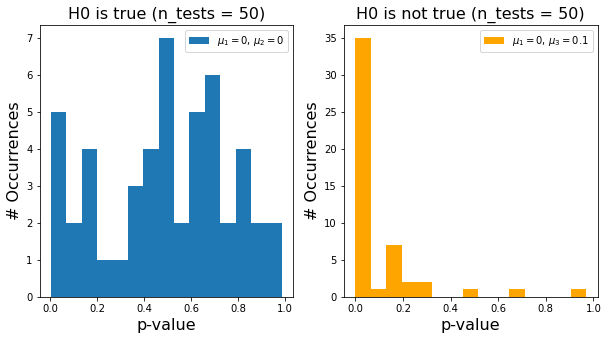

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
_ = axes[0].hist(pvalues12_H0_true, 15, label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}')
_ = axes[1].hist(pvalues12_H0_false, 15, label=f'$\\mu_1=${mean1}, $\\mu_3=${mean3}', color='orange')
axes[0].set_xlabel('p-value', fontsize=16)
axes[1].set_xlabel('p-value', fontsize=16)
axes[0].set_ylabel('# Occurrences', fontsize=16)
axes[1].set_ylabel('# Occurrences', fontsize=16)
axes[0].legend()
axes[1].legend()

axes[0].set_title(f'H0 is true (n_tests = {n_samples_from_1})', fontsize=16)
axes[1].set_title(f'H0 is not true (n_tests = {n_samples_from_2})', fontsize=16)

In reality, we don't know from which distribution a p-value comes - so we need a good cutoff-value to limit the number of false positives and false negatives we do. Now, do get a different look on the p-values, we pool all calculated values (remember, in reality we do not know whether a p-value corresponds to the case of H0 being true or not) and plot them against their common statistical rank.

We first calculate the rank: 

In [10]:
pvalues = pvalues12_H0_true + pvalues12_H0_false
ids = [0] * n_samples_from_1 + [1] * n_samples_from_2
results_sorted = np.sort(pvalues)
ids_sorted = np.asarray(ids)[np.argsort(pvalues)]

ranks = stats.rankdata(results_sorted)

And plot:

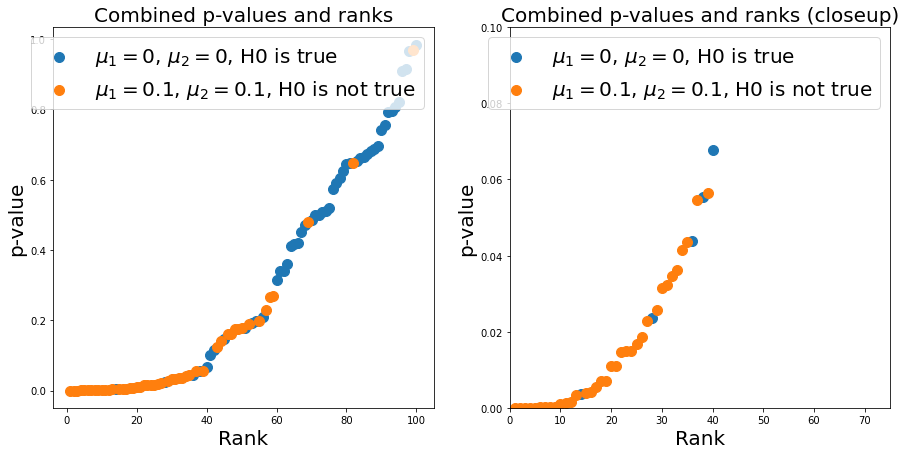

In [11]:
fs = 20
size = 100
fig, axes = plt.subplots(ncols=2, figsize=(15,7))
axes[0].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[0].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)

axes[1].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[1].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)
axes[1].set_xlim(0, 75)
axes[1].set_ylim(0, 0.1)

axes[0].set_title(f'Combined p-values and ranks', fontsize=fs)
axes[1].set_title(f'Combined p-values and ranks (closeup)', fontsize=fs)

for ax in axes:
    ax.legend(fontsize=fs)
    ax.set_xlabel('Rank', fontsize=fs)
    ax.set_ylabel('p-value', fontsize=fs)

Now, setting a good $\alpha$-value corresponds to setting a p-value threshold. For every point below this threshold, we come to the conclusion that H0 is false (i.e., the means of distribution 1 and 2 **are** different) or that H0 is true (i.e., the means of distribution 1 and 2 **are not** different). If we were to simply keep our $\alpha=0.05$ rule, we would see that we would get quite a few false positives:

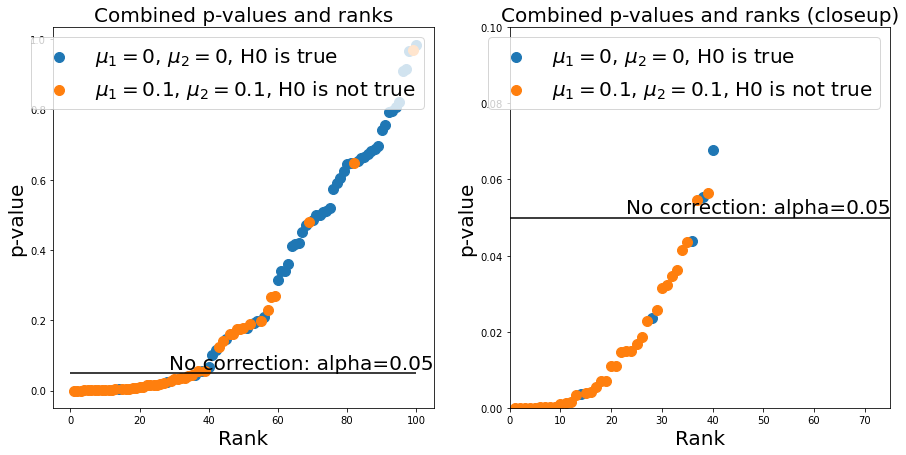

In [12]:
n_repeats  = n_samples_from_1 + n_samples_from_2

fig, axes = plt.subplots(ncols=2, figsize=(15,7))
axes[0].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[0].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)

axes[1].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[1].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)
axes[1].set_xlim(0, 75)
axes[1].set_ylim(0, 0.1)

axes[0].set_title(f'Combined p-values and ranks', fontsize=fs)
axes[1].set_title(f'Combined p-values and ranks (closeup)', fontsize=fs)

for ax in axes:
    ax.legend(fontsize=fs)
    ax.set_xlabel('Rank', fontsize=fs)
    ax.set_ylabel('p-value', fontsize=fs)
    ax.hlines(0.05, 0, n_repeats, 'k')
    ax.annotate('No correction: alpha=0.05', (ax.get_xlim()[1], 0.05), verticalalignment='bottom', horizontalalignment = 'right', fontsize=fs)

We could use the Bonferroni correction - this demands that we set $\alpha$ to $\alpha=\frac{\alpha}{N}$, where $N$ is the number of experiments. We can now see that the number of false positives is much lower (good!), but at the same time we get a lot of false negatives (bad!), which limits the statistical power of our test:

In [13]:
alpha_bonferroni = 0.05/(n_samples_from_1 + n_samples_from_2)

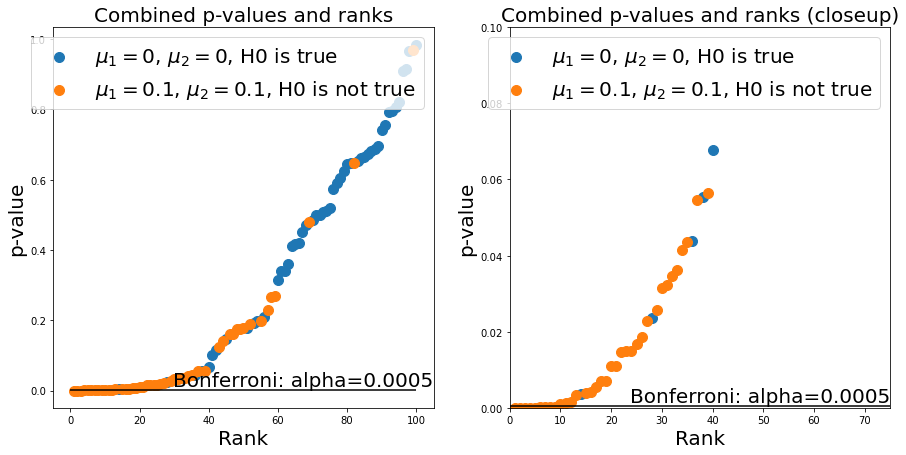

In [14]:
n_repeats  = n_samples_from_1 + n_samples_from_2

fig, axes = plt.subplots(ncols=2, figsize=(15,7))
axes[0].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[0].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)

axes[1].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[1].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)
axes[1].set_xlim(0, 75)
axes[1].set_ylim(0, 0.1)

axes[0].set_title(f'Combined p-values and ranks', fontsize=fs)
axes[1].set_title(f'Combined p-values and ranks (closeup)', fontsize=fs)

for ax in axes:
    ax.legend(fontsize=fs)
    ax.set_xlabel('Rank', fontsize=fs)
    ax.set_ylabel('p-value', fontsize=fs)
    ax.hlines(alpha_bonferroni, 0, n_repeats, 'k')
    ax.annotate(f'Bonferroni: alpha={alpha_bonferroni}', (ax.get_xlim()[1], alpha_bonferroni), verticalalignment='bottom', horizontalalignment = 'right', fontsize=fs)

The Banjamini-Hochberg method provides a trade-off between the two. It corresponds to drawing a line with the slope $\frac{\alpha}{N}*k$ where $k$ is the rank of a given p-value in the plot. We can use the [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html) package to calculate this easily. You see that it effectively gets rid of most false positives (still allowing some) while avoiding a high number of false negatives:

In [15]:
rejected, corrected_pvals = multitest.fdrcorrection(pvalues)
alpha_benjamini_hochberg = np.asarray(pvalues)[rejected].max()

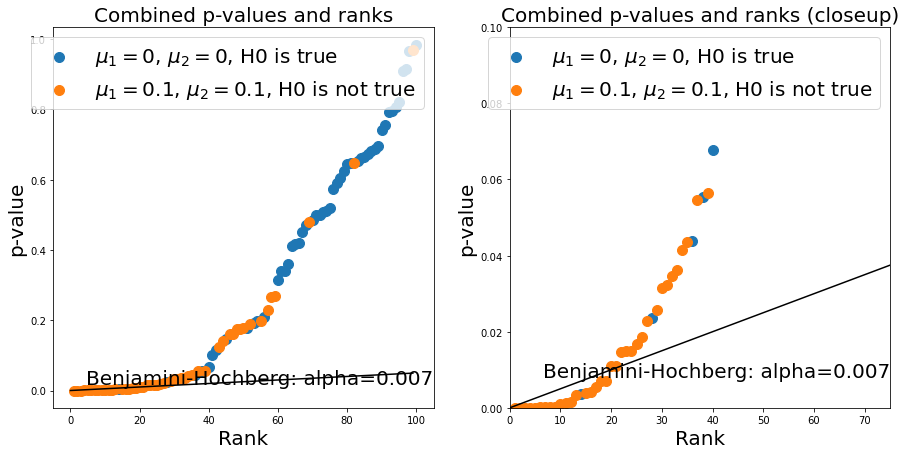

In [16]:
n_repeats  = n_samples_from_1 + n_samples_from_2

fig, axes = plt.subplots(ncols=2, figsize=(15,7))
axes[0].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[0].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)
axes[0].plot(np.arange(n_repeats), 0.05/n_repeats*np.arange(n_repeats), color='k')

axes[1].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[1].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)
axes[1].plot(np.arange(n_repeats), 0.05/n_repeats*np.arange(n_repeats), color='k')
axes[1].set_xlim(0, 75)
axes[1].set_ylim(0, 0.1)

axes[0].set_title(f'Combined p-values and ranks', fontsize=fs)
axes[1].set_title(f'Combined p-values and ranks (closeup)', fontsize=fs)

for ax in axes:
    ax.legend(fontsize=fs)
    ax.set_xlabel('Rank', fontsize=fs)
    ax.set_ylabel('p-value', fontsize=fs)
    ax.annotate('Benjamini-Hochberg: alpha={:.3f}'.format(alpha_benjamini_hochberg), (ax.get_xlim()[1], alpha_benjamini_hochberg), verticalalignment='bottom', horizontalalignment = 'right', fontsize=fs)

Text(75.0, 0.007035210499115585, 'Benjamini-Hochberg: alpha=0.007')

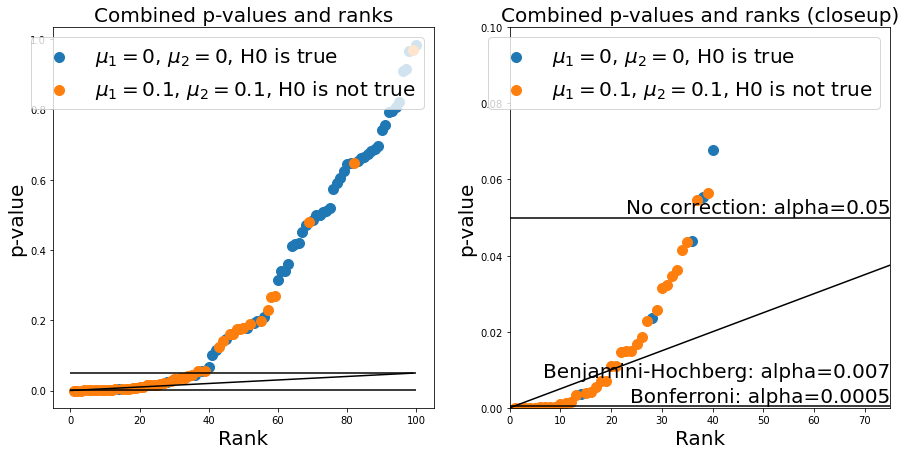

In [17]:
n_repeats  = n_samples_from_1 + n_samples_from_2

fig, axes = plt.subplots(ncols=2, figsize=(15,7))
axes[0].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[0].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)
axes[0].plot(np.arange(n_repeats), 0.05/n_repeats*np.arange(n_repeats), color='k')

axes[1].scatter(ranks[np.argwhere(ids_sorted==0).squeeze()], results_sorted[np.argwhere(ids_sorted==0).squeeze()],
           label=f'$\\mu_1=${mean1}, $\\mu_2=${mean2}, H0 is true', s=size)
axes[1].scatter(ranks[np.argwhere(ids_sorted==1).squeeze()], results_sorted[np.argwhere(ids_sorted==1).squeeze()],
           label=f'$\\mu_1=${mean3}, $\\mu_2=${mean3}, H0 is not true', s=size)
axes[1].plot(np.arange(n_repeats), 0.05/n_repeats*np.arange(n_repeats), color='k')
axes[1].set_xlim(0, 75)
axes[1].set_ylim(0, 0.1)

axes[0].set_title(f'Combined p-values and ranks', fontsize=fs)
axes[1].set_title(f'Combined p-values and ranks (closeup)', fontsize=fs)

for ax in axes:
    ax.legend(fontsize=fs)
    ax.set_xlabel('Rank', fontsize=fs)
    ax.set_ylabel('p-value', fontsize=fs)
    ax.hlines(alpha_bonferroni, 0, n_repeats, 'k')
    ax.hlines(0.05, 0, n_repeats, 'k')
    
ax.annotate('No correction: alpha=0.05', (ax.get_xlim()[1], 0.05), verticalalignment='bottom', horizontalalignment = 'right', fontsize=fs)
ax.annotate(f'Bonferroni: alpha={alpha_bonferroni}', (ax.get_xlim()[1], alpha_bonferroni), verticalalignment='bottom', horizontalalignment = 'right', fontsize=fs)
ax.annotate('Benjamini-Hochberg: alpha={:.3f}'.format(alpha_benjamini_hochberg), (ax.get_xlim()[1], alpha_benjamini_hochberg), verticalalignment='bottom', horizontalalignment = 'right', fontsize=fs)

## Exercise

Change the values at the top of the notebook (i.e., mean of the distributions or number drawn from both distributions). What do you observe? Discuss: For what types of experiment would you consider either of the methods more appropriate?